In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, kruskal
# Packages of forecasting models
from stldecompose import decompose, forecast
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Auxilliary functions

In [2]:
def augment_store_data (store_df, loc_weather_df):
    ## PREPROCESS THE ORIGINAL STORE DATA
    
    # Drop unnamed column and listino column, we won't be using those
    store_df = store_df.drop(["Unnamed: 0", "listino"], axis=1)

    # Build datetime index
    store_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in store_df[["settimana", "anno"]].values]
    store_df = store_df.set_index(["time"])
    store_df.index = pd.to_datetime(store_df.index) # make ts

    # Sort the data based on the new time index
    store_df.sort_index(inplace=True)

    # Aggregate the data to get the total sales of each week
    store_weekly_totals = store_df.groupby(pd.Grouper(freq = "W-MON")).agg({
        "vendita": np.sum,
        "settimana": np.min, 
        "anno": np.min,
    })

    # Check for NAN values and replace them if they are present
    nan_indices = store_weekly_totals[store_weekly_totals.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        store_weekly_totals.loc[nan_idx, "vendita"] = np.mean(store_weekly_totals.loc[:nan_idx,"vendita"].values)
        store_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
        store_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
        
    # Drop 2020 data (we won't be using them)
    store_weekly_totals.drop(store_weekly_totals.loc["2020"].index, inplace=True)
    # Drop the year data (we won't be using it)
    store_weekly_totals.drop("anno", axis=1, inplace=True)
    # Transform the week into sin(week#/53 * 2pi) * cos(week#/53 * 2pi)
    week_nr_values = store_weekly_totals.settimana.values
    store_weekly_totals["sin_week"] =  np.sin((week_nr_values/53) * 2*np.pi)
    store_weekly_totals["cos_week"] = np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_totals["sincos_week"] = np.sin((week_nr_values/53) * 2*np.pi) * np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_totals.drop("settimana", axis=1, inplace=True) # drop the actual week number values now


    ## PREPROCESS AND ADD WEATHER DATA
    
    # Converting the index as datetime index
    loc_weather_df = loc_weather_df.set_index(["DATA"])
    loc_weather_df.index = pd.to_datetime(loc_weather_df.index) # make ts
   
    # We can't really group the different weather fenomenons happening each day that column can't be used
    # Also the rain and average pressure cols are useless, they only have values of 0 or nan.
    # We won't be using those either 
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_weekly_totals.index[0]:,:]
    # Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
    loc_weather_df = loc_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
    loc_weather_df["PRESSIONESLM mb"] = loc_weather_df["PRESSIONESLM mb"].fillna(np.mean(loc_weather_df["PRESSIONESLM mb"]))
    
    weather_nan_indices = loc_weather_df[loc_weather_df.isnull().any(axis=1)].index
    print(weather_nan_indices)
    for nan_idx in weather_nan_indices:
        for col in loc_weather_df.columns[:-1]:
            n_days_before = nan_idx - timedelta(weeks=1)
            loc_weather_df.loc[nan_idx, col] = np.mean(loc_weather_df.loc[n_days_before:nan_idx, col])

    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_weekly_weather_augmented = store_weekly_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_weekly_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
    
    return store_weekly_totals, store_weekly_weather_augmented

# Load and clean data

In [3]:
## Store sales data

# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")

# Turin data
turin_data_df = pd.read_csv("../datasets/dati_nunalie/TORINO/TORIN.csv")

# Rome data
rome_data_df = pd.read_csv("../datasets/dati_nunalie/ROMA/RMNAZ.csv")
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TIBUR.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC1.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC2.csv"))


print("Milan sales data")
print(milan_data_df.head())
print("\n")
print("Turin sales data")
print(turin_data_df.head())
print("\n")
print("Rome sales data")
print(rome_data_df.head())
print("\n\n")

## Exogenous weather data

# weather
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv")
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv")

Milan sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0        8313  16SF181BNE-16        1         16  2016     XS   ARESE     LSI
1        8511  VA515233NE-16        1         16  2016     XS   ARESE     LSI
2        8569  16SF181BBL-16        1         16  2016      S   ARESE     LSI
3        8807   ZR121FABI-16        2         16  2016     UN   ARESE     LSI
4        8833  16SF181BNE-16        1         16  2016      S   ARESE     LSI


Turin sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0         150      BB37NE-16        1         12  2016      M   TORIN     LSI
1         163      CC13FA-16        2         12  2016      L   TORIN     LSI
2         164      CC13FA-16        1         12  2016     XL   TORIN     LSI
3         280      7126NE-16        1         12  2016     XS   TORIN     LSI
4         308      BB37NE-16        1         12  2016      L   TORIN     LSI


Rome sales data
   Unnamed

In [4]:
# Augment single location sales data and then put everything together
milan_weekly_default, milan_weekly_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_weekly_default.shape)
print("Milan + exogenous data shape:", milan_weekly_augmented.shape)
turin_weekly_default, turin_weekly_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_weekly_default.shape)
print("Turin + exogenous data shape:", turin_weekly_augmented.shape)
rome_weekly_default, rome_weekly_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_weekly_default.shape)
print("Rome + exogenous data shape:", rome_weekly_augmented.shape)

DatetimeIndex(['2016-01-25', '2016-02-01', '2016-02-08', '2016-02-22',
               '2016-02-29', '2016-03-07', '2016-03-21', '2016-03-28',
               '2016-04-04', '2016-04-25', '2016-05-02', '2016-05-09',
               '2016-05-23', '2016-05-30', '2016-06-06', '2016-06-20',
               '2016-06-27', '2016-07-04', '2016-07-25', '2016-08-01',
               '2016-08-08', '2016-08-22', '2016-08-29', '2016-09-05',
               '2016-09-19', '2016-09-26', '2016-10-03', '2016-10-10',
               '2016-10-24', '2016-10-31', '2016-11-07'],
              dtype='datetime64[ns]', name='DATA', freq=None)
Milan data original shape: (195, 4)
Milan + exogenous data shape: (195, 14)
DatetimeIndex(['2016-01-25', '2016-02-01', '2016-02-22', '2016-02-29'], dtype='datetime64[ns]', name='DATA', freq=None)
Turin data original shape: (199, 4)
Turin + exogenous data shape: (199, 14)
DatetimeIndex(['2016-01-25', '2016-02-01', '2016-02-22', '2016-02-29',
               '2016-03-21', '2016-03-28

In [5]:
## Create dicts for different store data
datasets = {
    "Milan": milan_weekly_augmented,
    #"Turin": turin_weekly_augmented, 
    #"Rome": rome_weekly_augmented
}

# Data Visualization and Exploration 

Milan data 



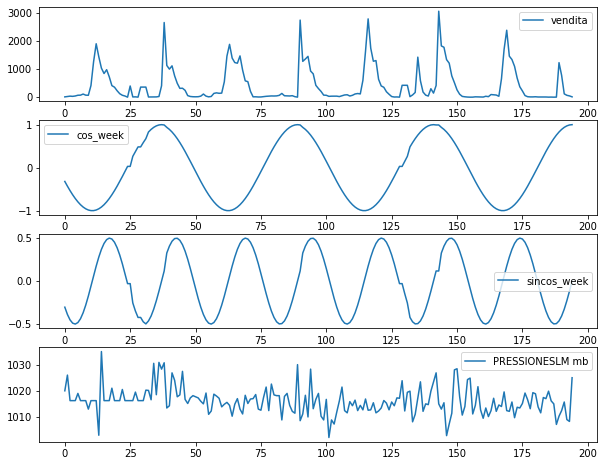

In [6]:
# Plot the data to explore and see what we are working with
for dataset in datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = datasets[dataset].values
    cols_to_plot = cols_with_most_corr(datasets[dataset], 0)
    #cols_to_plot = [0,1,2,3]
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

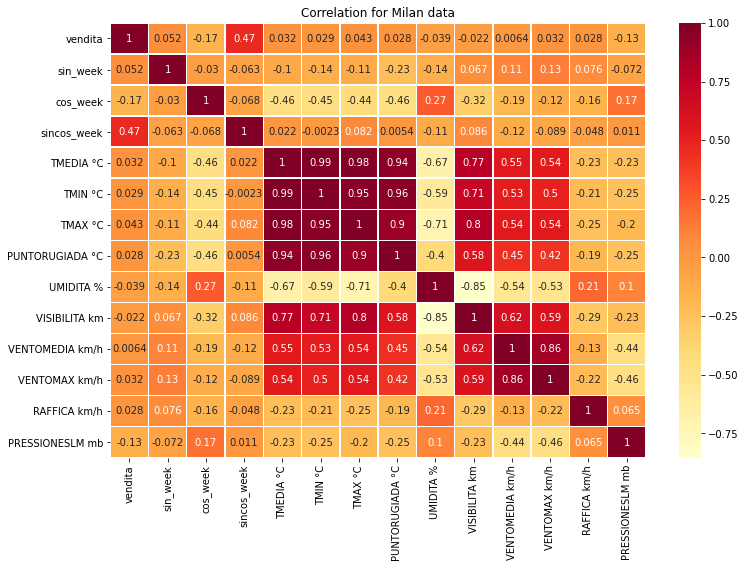

In [7]:
## Correlation matrix: Spearman Correlation
for dataset in datasets:
    # Default data
    default_s_corr = datasets[dataset].corr(method="spearman")
    plt.figure(figsize=(12,8))
    sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.5)
    plt.title("Correlation for "+ dataset+" data")
    plt.show()

# LSTM helper functions

In [8]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len=54, out_len=39):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [9]:
def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

In [10]:
def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=len(input_features)*4, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

In [11]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len=54, out_len=39):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

# Forecasting evaluation

In [25]:
single_run_results = []
n_runs = 2

for dataset in datasets:
    print("Running forecasting for sales in", dataset)
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        full_dataset = datasets[dataset]

        # Create training and test data
        train, test = ts_train_test_split(full_dataset)
       
        #default_desired_input_features = cols_with_most_corr(train.iloc[:, :4])
        #aug_desired_input_features = cols_with_most_corr(train)
      
        # Extract the columns which display most correlation with the value we are trying to predict.
        mono_input_features = [0]
        exo1_input_features = [0, 1, 2, 3]
        exo2_input_features = [0] + list(range(4,full_dataset.shape[1]))
        exo3_input_features = list(range(0,full_dataset.shape[1]))
        print("MONO-LSTM input features:", mono_input_features)
        print("EXO1 (+ sincos day) input features :", exo1_input_features)
        print("EXO2 (+ weather exog) input features :", exo2_input_features)
        print("EXO3 (+ all exog) input features :", exo3_input_features)
        print()
        
        ## Run STL Decomposition as baseline
        print("Running Drift and Seasonal Drift models based on STL Decomposition...")
        f_steps = test.shape[0]
        decomp = decompose(train.vendita, period=52)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
        drift_rmse = sm.tools.eval_measures.rmse(test.vendita.values, drift_forecast["drift+seasonal"].values)
        drift_mae = sm.tools.eval_measures.meanabs(test.vendita.values, drift_forecast["drift+seasonal"].values)
        print("Done\n")
        
        ## Run ARIMA as another baseline
        #print("Running SARIMA model...")
        ## Fit your model
        #sarima_model = pm.auto_arima(def_train.vendita, seasonal=True, m=52, suppress_warnings=True, max_order=None, \
        #                            start_p=3, start_q=0, start_P=0, start_Q=0, \
        #                            max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        ## Get model params
        #sarima_order = sarima_model.get_params()["order"]
        #sarima_s_order = sarima_model.get_params()["seasonal_order"]
        ## Predict #test steps into the future
        #sarima_forecasts = sarima_model.predict(f_steps)  
        #sarima_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values, sarima_forecasts)
        #sarima_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values, sarima_forecasts)
        #print("Done\n")
        
        #print("Running SARIMAX model...")
        #sarimax_model = SARIMAX(endog=aug_train.vendita, exog=aug_train.iloc[:, aug_desired_input_features[1:]], \
        #                        order=sarima_order, seasonal_order=sarima_s_order)
        #sarimax_fitted = sarimax_model.fit()
        #sarimax_forecasts = sarimax_fitted.forecast(f_steps, exog=aug_test.iloc[:, aug_desired_input_features[1:]])  
        #sarimax_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values, sarimax_forecasts)
        #sarimax_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values, sarimax_forecasts)
        #print("Done\n")
        
        ## LSTM
        # Define the LSTM Models and their Optimizer objects
        mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
        exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
        exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
        exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)

        # 1) MONO-LSTM data
        mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=54, out_len=f_steps)
        mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
        mono_x_test=torch.Tensor(mono_inp_te)

        # 2) EXO1-LSTM data
        exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=54, out_len=f_steps)
        exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
        exo1_x_test=torch.Tensor(exo1_inp_te)

        # 3) EXO2-LSTM data
        exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=54, out_len=f_steps)
        exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
        exo2_x_test=torch.Tensor(exo2_inp_te)

        # 4) EXO3-LSTM data
        exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=54, out_len=f_steps)
        exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
        exo3_x_test=torch.Tensor(exo3_inp_te)

        # Train all the LSTMs 
        print("Training the MONO-LSTM model...")
        mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=10+len(mono_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO1-LSTM model...")
        #exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
        #                   do_teacher_forcing=True, n_epochs=10+len(exo1_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO2-LSTM model...")
        #exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
        #                   do_teacher_forcing=True, n_epochs=10+len(exo2_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO3-LSTM model...")
        exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=10+len(exo3_input_features)*3, batch_size=8)
        print("Done\n")

        # Make predictions using the trained networks
        mono_pred = mono_LSTM_Model(mono_x_test, f_steps)
        exo1_pred = exo1_LSTM_Model(exo1_x_test, f_steps)
        exo2_pred = exo2_LSTM_Model(exo2_x_test, f_steps)
        #exo1_pred_two = exo1_LSTM_Model.predict_mono(exo1_x_test, f_steps, torch.Tensor(exo1_out_te))
        exo3_pred = exo3_LSTM_Model(exo3_x_test, f_steps)
        exo3_pred_two = exo3_LSTM_Model.predict_mono(exo3_x_test, f_steps, torch.Tensor(exo3_out_te))


        ## Check results of LSTM forecasts (calc erros)
        mean = np.mean(train.vendita.values)
        std = np.std(train.vendita.values)
        mono_lstm_rmse, mono_lstm_mae = check_lstm_forecast_results(mono_pred, mono_inp_te, mono_out_te, mean, std, in_len=54, out_len=f_steps)
        #exo1_lstm_rmse, exo1_lstm_mae = check_lstm_forecast_results(exo1_pred, exo1_inp_te, exo1_out_te, mean, std, in_len=54, out_len=f_steps)
        #exo2_lstm_rmse, exo2_lstm_mae = check_lstm_forecast_results(exo2_pred, exo2_inp_te, exo2_out_te, mean, std, in_len=54, out_len=f_steps)
        exo3_lstm_rmse, exo3_lstm_mae = check_lstm_forecast_results(exo3_pred, exo3_inp_te, exo3_out_te, mean, std, in_len=54, out_len=f_steps)
        #mono_two_lstm_rmse, mono_two_lstm_mae = check_lstm_forecast_results(mono_pred_two, mono_inp_te, mono_out_te, mean, std, in_len=54, out_len=f_steps)
        exo3_two_lstm_rmse, exo3_two_lstm_mae = check_lstm_forecast_results(exo3_pred_two, exo3_inp_te, exo3_out_te, mean, std, in_len=54, out_len=f_steps)
        
        fig = go.Figure()
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=test.vendita,
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                    mode='lines', name='SDRIFT'))
        #fig.add_trace(go.Scatter(x=x_labels, y=arima_forecasts,
        #            mode='lines', name='SARIMA'+str(arima_order)))
        #fig.add_trace(go.Scatter(x=x_labels, y=arimax_forecasts,
        #            mode='lines', name='SARIMAX'+str(arima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=(mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='MONO-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo1_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO1-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo2_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO2-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO3-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred_two[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO3-LSTM-TWO'))
        #Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, mono_lstm_rmse, \
                                   exo1_lstm_rmse, exo2_lstm_rmse, exo3_lstm_rmse, \
                                   drift_mae, mono_lstm_mae, exo1_lstm_mae, \
                                   exo2_lstm_mae, exo3_lstm_mae])
    
        print()

Running forecasting for sales in Milan
Run # 1
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.10. Validation loss: 1.08. Avg future: 31.86. Elapsed time: 0.4


Run # 2
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.14. Validation loss: 1.14. Avg future: 19.57. Elapsed time: 0.42s.
Epoch 2 Train loss: 1.13. Validati

In [26]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, 
                                     columns=["Dataset", "Run Nr.", "DRIFT RMSE", \
                                              "MONO-LSTM RMSE", "EXO1-LSTM RMSE", "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
                                              "DRIFT MAE", "MONO-LSTM MAE",\
                                              "EXO1-LSTM MAE", "EXO2-LSTM MAE", "EXO3-LSTM MAE"])
single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,MONO-LSTM RMSE,EXO3-LSTM RMSE,EXO3-LSTM-TWO RMSE,DRIFT MAE,MONO-LSTM MAE,EXO3-LSTM MAE,EXO3-LSTM-TWO MAE
0,Milan,run 1,475.461482,573.879709,332.854087,361.240743,284.260058,462.144673,201.399411,224.324107
1,Milan,run 2,475.461482,579.783006,355.029457,387.699780,284.260058,483.934255,220.206987,264.212931


In [27]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,MONO-LSTM RMSE,EXO3-LSTM RMSE,EXO3-LSTM-TWO RMSE,DRIFT MAE,MONO-LSTM MAE,EXO3-LSTM MAE,EXO3-LSTM-TWO MAE
Dataset,,,,,,,,
Milan,475.461482,576.831358,343.941772,374.470262,284.260058,473.039464,210.803199,244.268519


In [ ]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
#ax = sns.scatterplot(x=mean_results.index, y="SARIMA RMSE", data=mean_results, label="SARIMA")
#ax = sns.scatterplot(x=mean_results.index, y="SARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM RMSE", data=mean_results, label="MONOLSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM RMSE", data=mean_results, label="EXO1-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM RMSE", data=mean_results, label="EXO2-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM RMSE", data=mean_results, label="EXO3-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
#aax = sns.scatterplot(x=mean_results.index, y="SARIMA MAE", data=mean_results, label="SARIMA")
#aax = sns.scatterplot(x=mean_results.index, y="SARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM MAE", data=mean_results, label="MONOLSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM MAE", data=mean_results, label="EXO1-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM MAE", data=mean_results, label="EXO2-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM MAE", data=mean_results, label="EXO3-LSTM")
aax.set(ylabel="MAE")
plt.show()